# Generative Adversarial Network

In this notebook, we'll be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits! We will use the loss functions and models we built in the previous exercises.


The idea behind GANs is that you have two networks, a generator $G$ and a discriminator $D$, competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake. 
>* The generator is trained to fool the discriminator, it wants to output data that looks _as close as possible_ to real, training data. 
>* The discriminator is a classifier that is trained to figure out which data is real and which is fake. 

What ends up happening is that the generator learns to make data that is indistinguishable from real data to the discriminator.

<img src='assets/gan_pipeline.png' width=70% />

The general structure of a GAN is shown in the diagram above, using MNIST images as data. The latent sample is a random vector that the generator uses to construct its fake images. This is often called a **latent vector** and that vector space is called **latent space**. As the generator trains, it figures out how to map latent vectors to recognizable images that can fool the discriminator.

In this notebook, we will be using the [MNIST Dataset](http://yann.lecun.com/exdb/mnist/), a dataset of handwritten digits. We can use the torch [Datasets API](https://pytorch.org/vision/stable/datasets.html) to load the whole dataset directly. The MNIST dataset is made of 28x28 grayscale images.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [129]:
from torchvision import datasets
import torchvision.transforms as transforms

IMAGE_SIZE = 32
CHANNELS_IMG = 1
# number of subprocesses to use for data loading
num_workers = 4
# how many samples per batch to load
batch_size = 128

# convert data to torch.FloatTensor
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
    ]
)

# get the training datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transforms)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size,
                                           num_workers=num_workers)

### Visualize the data

We visualize a single random example of the MNIST dataset. You can rerun this cell multiple times to see different logits.

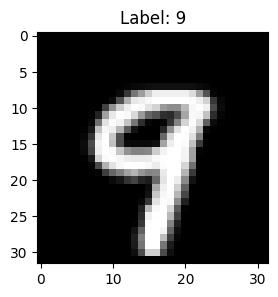

In [130]:
# obtain one batch of training images
rand_index = np.random.randint(0, len(train_data), 1)[0]
images = train_data[rand_index][0]
label = train_data[rand_index][1]
images = images.numpy()
# get one image from the batch
img = np.squeeze(images[0])

fig = plt.figure(figsize = (3,3)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

---
# Define the Model

A GAN is comprised of two adversarial networks, a discriminator and a generator. In this exercise, we will be using the Generator and Discriminator we previously built.

## Discriminator

In [131]:
import torch.nn as nn

In [132]:
class Discriminator(nn.Module):
    """
    The discriminator model adapted from the DCGAN paper. It should only contains a few layers.
    args:
    - conv_dim: control the number of filters
    """
    def __init__(self, conv_dim: int, dropout: float = 0.5):
        super().__init__()
        self.conv_dim = conv_dim
        ####
        # IMPLEMENT HERE
        ####
        self.conv1 = self._block(in_channels=1, out_channels=conv_dim, kernel_size=4, bias=True, batch_norm = False) # 32x32 -> 16x16
        self.conv2 = self._block(in_channels=conv_dim, out_channels=conv_dim*2, kernel_size=4, bias=False) # 16x16 -> 8x8
        self.conv3 = self._block(in_channels=conv_dim*2, out_channels=conv_dim*4, kernel_size=4, bias=False) # 8x8 -> 4x4
        self.conv4 = self._block(in_channels=conv_dim*4, out_channels=1, kernel_size=4, padding=0, bias=False) # 4x4 -> 1x1
        
        # get rid of any fully connected layer with respect to the DCGAN paper
        # self.flatten = nn.Flatten()
        # self.fc1 = nn.Linear((4*4)*(conv_dim*4), 1)
    
    def _block(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int = 2, 
                 padding: int = 1,
                 bias: bool = False,
                 batch_norm: bool = True):
        """
        A convolutional block is made of 3 layers: Conv -> BatchNorm -> Activation.
        args:
        - in_channels: number of channels in the input to the conv layer
        - out_channels: number of filters in the conv layer
        - kernel_size: filter dimension of the conv layer
        - batch_norm: whether to use batch norm or not
        """
        if batch_norm:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(0.2)
            )
        else:
            return nn.Sequential(
                # in the DCGAN paper, they say not to use batchnorm on the first layer of descriminator and last layer of generator
                # however, in dicriminator, the bias will be canceled out in the following layers I think! so in the end, we don't have any bias!?
                nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.LeakyReLU(0.2)
            )
    def forward(self, x):
        ####
        # IMPLEMENT HERE
        ####      
        x = self.conv1(x)
        # print(f"shape at conv1: {x.shape}")
        x = self.conv2(x)
        # print(f"shape at conv2: {x.shape}")
        x = self.conv3(x)
        # print(f"shape at conv3: {x.shape}")
        x = self.conv4(x)
        # print(f"shape at conv4: {x.shape}")
        # x = self.flatten(x)
        x = x.squeeze()
        # print(x.shape)
        return x

## Generator

In [133]:
class Generator(nn.Module):
    """
    The generator model adapted from DCGAN
    args:
    - latent_dim: dimension of the latent vector 100x1x1
    - conv_dim: control the number of filters in the convtranspose layers
    """
    def __init__(self, latent_dim: int, conv_dim: int = 128, dropout: float = 0.5):
        super().__init__()
        ####
        # IMPLEMENT HERE
        ####
        self.conv_dim = conv_dim
        # self.fc1 = nn.Linear(latent_dim, conv_dim*4*4, bias=False)
        # reshape to (batch_size, conv_dim, 4, 4)
        self.tconv1 = self._block(in_channels=latent_dim, out_channels=conv_dim*4, kernel_size=4, stride=2, padding=0, bias=False)
        self.tconv2 = self._block(in_channels=conv_dim*4, out_channels=conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv3 = self._block(in_channels=conv_dim*2, out_channels=conv_dim, kernel_size=4, stride=2, padding=1, bias=False)
        self.tconv4 = self._block(in_channels=conv_dim, out_channels=1, kernel_size=4, stride=2, padding=1, bias=True, batch_norm=False)
    
    
    
    def _block(self, 
                 in_channels: int, 
                 out_channels: int, 
                 kernel_size: int, 
                 stride: int,
                 padding: int,
                 bias: bool = False,
                 batch_norm: bool = True):
        """
        A "de-convolutional" block is made of 3 layers: ConvTranspose -> BatchNorm -> Activation.
        args:
        - in_channels: number of channels in the input to the conv layer
        - out_channels: number of filters in the conv layer
        - kernel_size: filter dimension of the conv layer
        - stride: stride of the conv layer
        - padding: padding of the conv layer
        - batch_norm: whether to use batch norm or not
        """
        if batch_norm:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=bias),
                nn.Tanh(),
            )
            
    def forward(self, x):
        ####
        # IMPLEMENT HERE
        ####
        ## x = self.fc1(x)
        ## x = x.view(-1, self.conv_dim, 4, 4)
        # print(f"input {x.shape}")
        x = self.tconv1(x)
        # print(f"shape at conv1: {x.shape}")
        x = self.tconv2(x)
        # print(f"shape at conv2: {x.shape}")
        x = self.tconv3(x)
        # print(f"shape at conv3: {x.shape}")
        x = self.tconv4(x)
        # print(f"shape at conv4: {x.shape}")
        
        return x

## Model hyperparameters

In [134]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
# input_size = 784
# Size of last hidden layer in the discriminator
d_hidden_size = 64
# 32-64-32-16-1
# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
# g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 64
# 100-64-128-288

## Build complete network

Now we're instantiating the discriminator and generator from the classes defined above. Make sure you've passed in the correct input arguments.

In [135]:
def weights_init(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            torch.nn.init.normal_(m.weight.data, 0.0, 0.02)

In [136]:
# instantiate discriminator and generator
D = Discriminator(d_hidden_size, dropout=0)
G = Generator(z_size, g_hidden_size, dropout=0)

D.apply(weights_init);
G.apply(weights_init);
# check that they are as you expect
print(D)
print()
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
)

Generator(
  (tconv1): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(2, 2), bias=False)
    (1): Ba

---
## Discriminator and Generator Losses

Now we need to calculate the losses. For this exercise, we will use the loss functions we previously implemented. 

In [137]:
# Calculate losses
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    labels = labels.to(device)
    
    # print(f"Shape in RealLoss: {labels.shape}\nShape in DOUT: {D_out.shape}")
    # numerically stable loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    labels = labels.to(device)
    
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

## Optimizers

We want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [138]:
import torch.optim as optim

# Optimizers
# lr = 0.0002
lr = 2e-4
beta1 = 0.5
beta2 = 0.999 # default value
# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr,  (beta1, beta2))
g_optimizer = optim.Adam(G.parameters(), lr/2,  (beta1, beta2))

---
## Training

Training will involve alternating between training the discriminator and the generator. We'll use our functions `real_loss` and `fake_loss` to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [139]:
from datetime import datetime
import pickle as pkl

In [140]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(14,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.cpu().numpy().reshape((32,32)), cmap='Greys_r')
    plt.show()

2023-10-18 11:58:16 | Epoch [1/50] | Batch 0/469 | d_loss: 0.6931 | g_loss: 0.6930
2023-10-18 11:58:21 | Epoch [1/50] | Batch 100/469 | d_loss: 0.6912 | g_loss: 0.6931
2023-10-18 11:58:26 | Epoch [1/50] | Batch 200/469 | d_loss: 0.6894 | g_loss: 0.6929
2023-10-18 11:58:32 | Epoch [1/50] | Batch 300/469 | d_loss: 0.6874 | g_loss: 0.6928
2023-10-18 11:58:37 | Epoch [1/50] | Batch 400/469 | d_loss: 0.6859 | g_loss: 0.6927


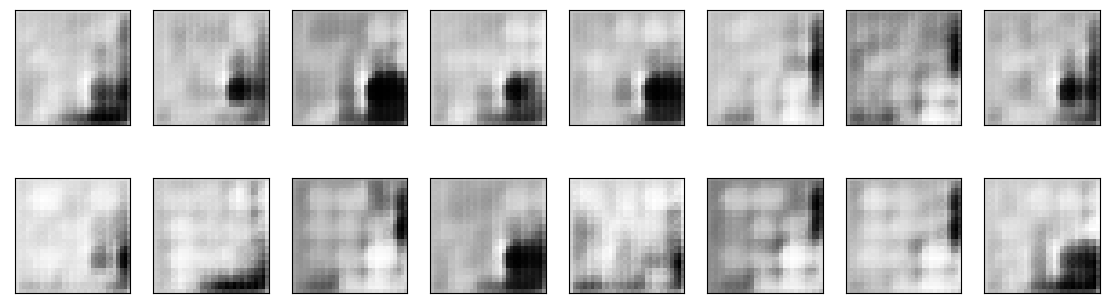

2023-10-18 11:58:42 | Epoch [2/50] | Batch 0/469 | d_loss: 0.6846 | g_loss: 0.6930
2023-10-18 11:58:47 | Epoch [2/50] | Batch 100/469 | d_loss: 0.6829 | g_loss: 0.6927
2023-10-18 11:58:52 | Epoch [2/50] | Batch 200/469 | d_loss: 0.6813 | g_loss: 0.6924
2023-10-18 11:58:58 | Epoch [2/50] | Batch 300/469 | d_loss: 0.6800 | g_loss: 0.6924
2023-10-18 11:59:03 | Epoch [2/50] | Batch 400/469 | d_loss: 0.6786 | g_loss: 0.6922


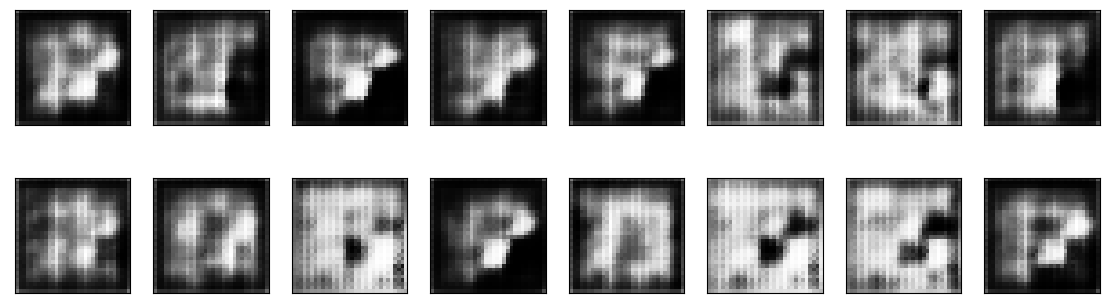

2023-10-18 11:59:08 | Epoch [3/50] | Batch 0/469 | d_loss: 0.6773 | g_loss: 0.6925
2023-10-18 11:59:13 | Epoch [3/50] | Batch 100/469 | d_loss: 0.6803 | g_loss: 0.6872
2023-10-18 11:59:19 | Epoch [3/50] | Batch 200/469 | d_loss: 0.6835 | g_loss: 0.6773
2023-10-18 11:59:24 | Epoch [3/50] | Batch 300/469 | d_loss: 0.6861 | g_loss: 0.6844
2023-10-18 11:59:29 | Epoch [3/50] | Batch 400/469 | d_loss: 0.6854 | g_loss: 0.6853


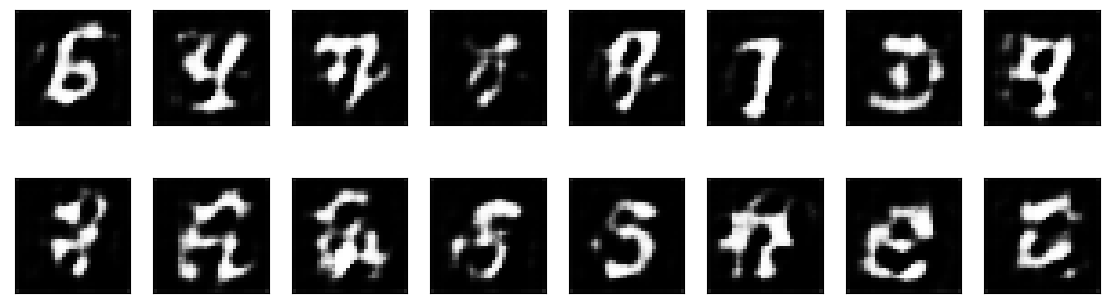

2023-10-18 11:59:34 | Epoch [4/50] | Batch 0/469 | d_loss: 0.6858 | g_loss: 0.6723
2023-10-18 11:59:40 | Epoch [4/50] | Batch 100/469 | d_loss: 0.6875 | g_loss: 0.6873
2023-10-18 11:59:45 | Epoch [4/50] | Batch 200/469 | d_loss: 0.6839 | g_loss: 0.6872
2023-10-18 11:59:51 | Epoch [4/50] | Batch 300/469 | d_loss: 0.6837 | g_loss: 0.6802
2023-10-18 11:59:56 | Epoch [4/50] | Batch 400/469 | d_loss: 0.6848 | g_loss: 0.6869


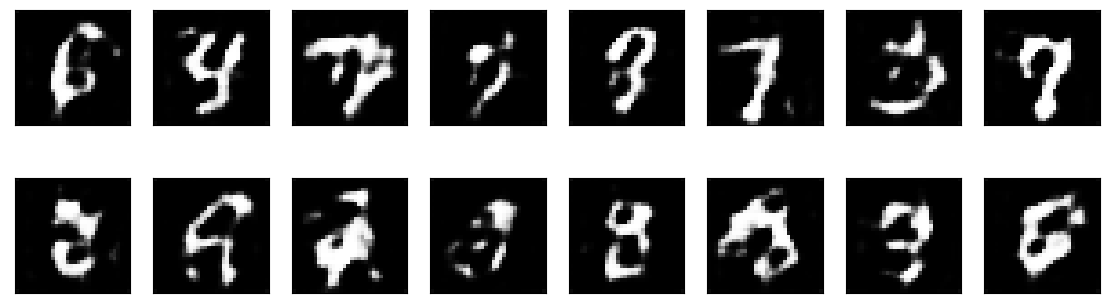

2023-10-18 12:00:01 | Epoch [5/50] | Batch 0/469 | d_loss: 0.6833 | g_loss: 0.6863
2023-10-18 12:00:07 | Epoch [5/50] | Batch 100/469 | d_loss: 0.6818 | g_loss: 0.6861
2023-10-18 12:00:12 | Epoch [5/50] | Batch 200/469 | d_loss: 0.6846 | g_loss: 0.6834
2023-10-18 12:00:17 | Epoch [5/50] | Batch 300/469 | d_loss: 0.6822 | g_loss: 0.6879
2023-10-18 12:00:23 | Epoch [5/50] | Batch 400/469 | d_loss: 0.6792 | g_loss: 0.6835


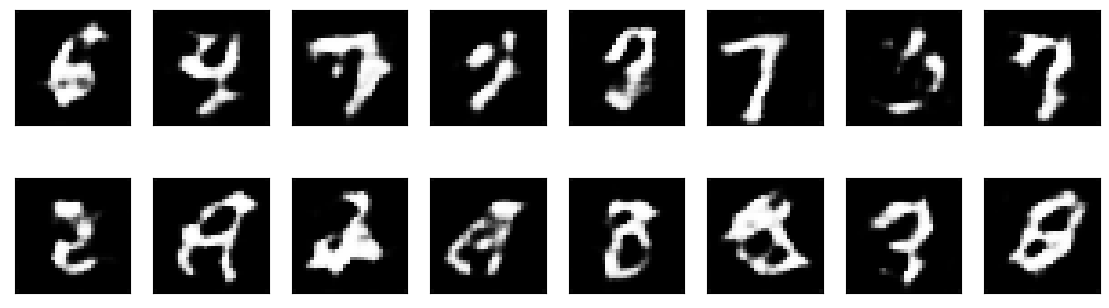

2023-10-18 12:00:28 | Epoch [6/50] | Batch 0/469 | d_loss: 0.6813 | g_loss: 0.6891
2023-10-18 12:00:33 | Epoch [6/50] | Batch 100/469 | d_loss: 0.6763 | g_loss: 0.6885
2023-10-18 12:00:38 | Epoch [6/50] | Batch 200/469 | d_loss: 0.6818 | g_loss: 0.6780
2023-10-18 12:00:44 | Epoch [6/50] | Batch 300/469 | d_loss: 0.6732 | g_loss: 0.6879
2023-10-18 12:00:50 | Epoch [6/50] | Batch 400/469 | d_loss: 0.6821 | g_loss: 0.6880


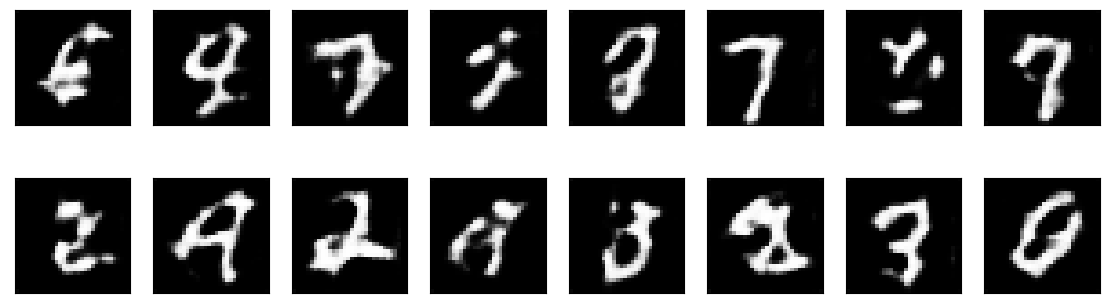

2023-10-18 12:00:54 | Epoch [7/50] | Batch 0/469 | d_loss: 0.6694 | g_loss: 0.6859
2023-10-18 12:01:01 | Epoch [7/50] | Batch 100/469 | d_loss: 0.6813 | g_loss: 0.6822
2023-10-18 12:01:06 | Epoch [7/50] | Batch 200/469 | d_loss: 0.6713 | g_loss: 0.6800
2023-10-18 12:01:13 | Epoch [7/50] | Batch 300/469 | d_loss: 0.6695 | g_loss: 0.6878
2023-10-18 12:01:18 | Epoch [7/50] | Batch 400/469 | d_loss: 0.6844 | g_loss: 0.6860


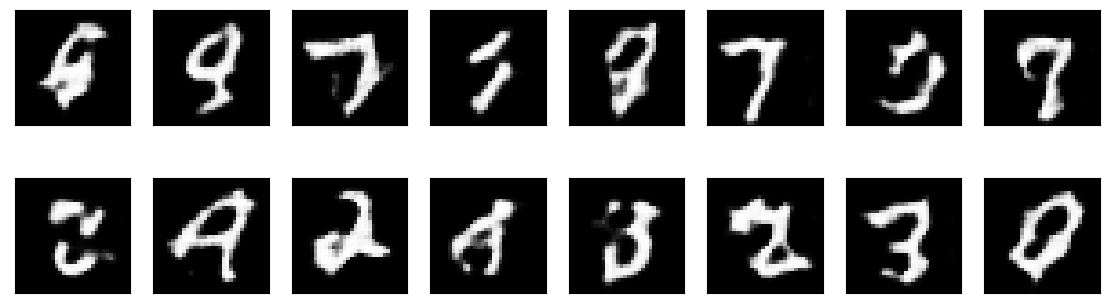

2023-10-18 12:01:24 | Epoch [8/50] | Batch 0/469 | d_loss: 0.6846 | g_loss: 0.6871
2023-10-18 12:01:29 | Epoch [8/50] | Batch 100/469 | d_loss: 0.6688 | g_loss: 0.6903
2023-10-18 12:01:34 | Epoch [8/50] | Batch 200/469 | d_loss: 0.6634 | g_loss: 0.6904
2023-10-18 12:01:40 | Epoch [8/50] | Batch 300/469 | d_loss: 0.6638 | g_loss: 0.6910
2023-10-18 12:01:45 | Epoch [8/50] | Batch 400/469 | d_loss: 0.6700 | g_loss: 0.6794


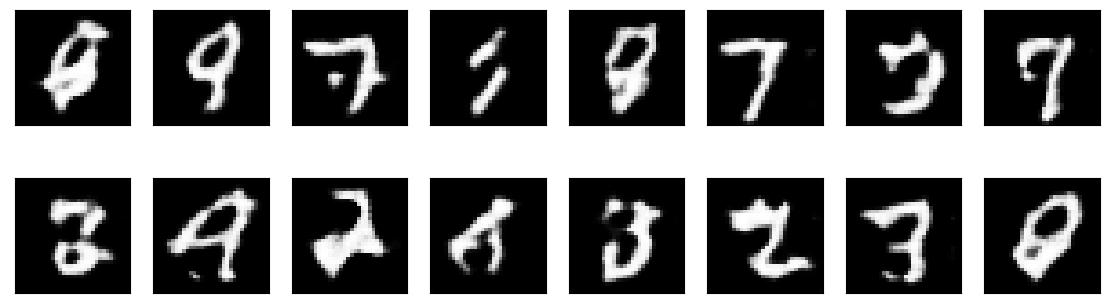

2023-10-18 12:01:50 | Epoch [9/50] | Batch 0/469 | d_loss: 0.6609 | g_loss: 0.6817
2023-10-18 12:01:56 | Epoch [9/50] | Batch 100/469 | d_loss: 0.6630 | g_loss: 0.6902
2023-10-18 12:02:01 | Epoch [9/50] | Batch 200/469 | d_loss: 0.6595 | g_loss: 0.6909
2023-10-18 12:02:06 | Epoch [9/50] | Batch 300/469 | d_loss: 0.6876 | g_loss: 0.6836
2023-10-18 12:02:11 | Epoch [9/50] | Batch 400/469 | d_loss: 0.6690 | g_loss: 0.6869


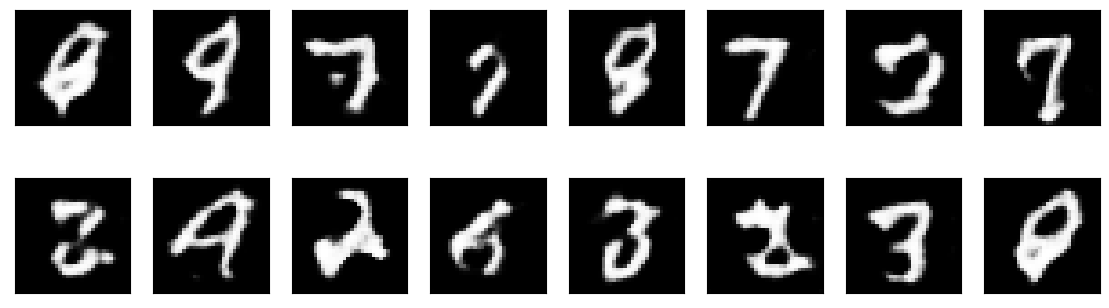

2023-10-18 12:02:17 | Epoch [10/50] | Batch 0/469 | d_loss: 0.6584 | g_loss: 0.6877
2023-10-18 12:02:23 | Epoch [10/50] | Batch 100/469 | d_loss: 0.6548 | g_loss: 0.6897
2023-10-18 12:02:29 | Epoch [10/50] | Batch 200/469 | d_loss: 0.6555 | g_loss: 0.6890
2023-10-18 12:02:35 | Epoch [10/50] | Batch 300/469 | d_loss: 0.6534 | g_loss: 0.6894
2023-10-18 12:02:41 | Epoch [10/50] | Batch 400/469 | d_loss: 0.6843 | g_loss: 0.6802


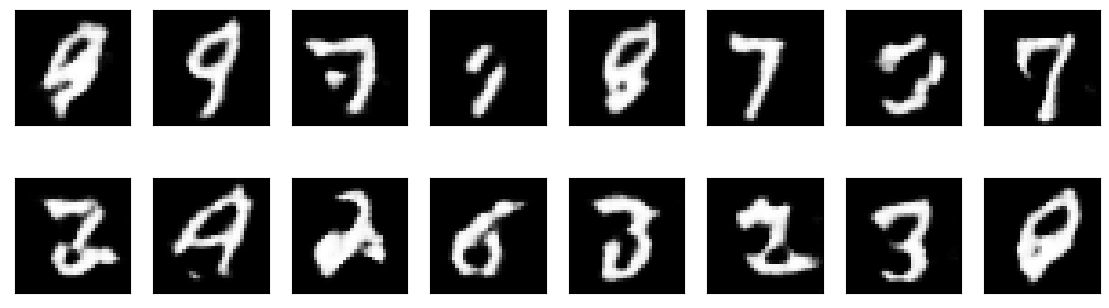

2023-10-18 12:02:46 | Epoch [11/50] | Batch 0/469 | d_loss: 0.6536 | g_loss: 0.6902
2023-10-18 12:02:51 | Epoch [11/50] | Batch 100/469 | d_loss: 0.6509 | g_loss: 0.6910
2023-10-18 12:02:57 | Epoch [11/50] | Batch 200/469 | d_loss: 0.6487 | g_loss: 0.6921
2023-10-18 12:03:02 | Epoch [11/50] | Batch 300/469 | d_loss: 0.6469 | g_loss: 0.6934
2023-10-18 12:03:08 | Epoch [11/50] | Batch 400/469 | d_loss: 0.6650 | g_loss: 0.6908


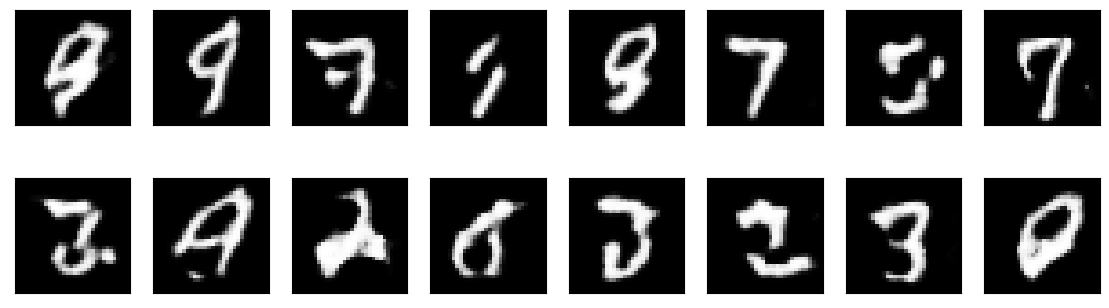

2023-10-18 12:03:13 | Epoch [12/50] | Batch 0/469 | d_loss: 0.6910 | g_loss: 0.6834
2023-10-18 12:03:19 | Epoch [12/50] | Batch 100/469 | d_loss: 0.6825 | g_loss: 0.6755
2023-10-18 12:03:25 | Epoch [12/50] | Batch 200/469 | d_loss: 0.6802 | g_loss: 0.6784
2023-10-18 12:03:29 | Epoch [12/50] | Batch 300/469 | d_loss: 0.6754 | g_loss: 0.6839
2023-10-18 12:03:35 | Epoch [12/50] | Batch 400/469 | d_loss: 0.6845 | g_loss: 0.6885


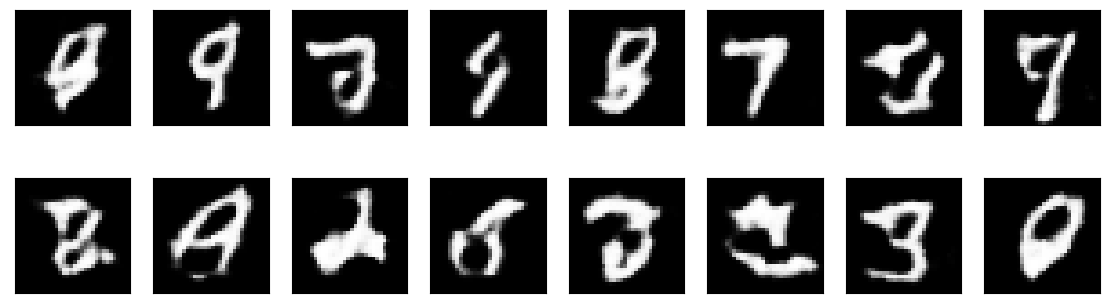

2023-10-18 12:03:40 | Epoch [13/50] | Batch 0/469 | d_loss: 0.6753 | g_loss: 0.6877
2023-10-18 12:03:46 | Epoch [13/50] | Batch 100/469 | d_loss: 0.6439 | g_loss: 0.6947
2023-10-18 12:03:51 | Epoch [13/50] | Batch 200/469 | d_loss: 0.6426 | g_loss: 0.6959
2023-10-18 12:03:56 | Epoch [13/50] | Batch 300/469 | d_loss: 0.6476 | g_loss: 0.6888
2023-10-18 12:04:02 | Epoch [13/50] | Batch 400/469 | d_loss: 0.6665 | g_loss: 0.6926


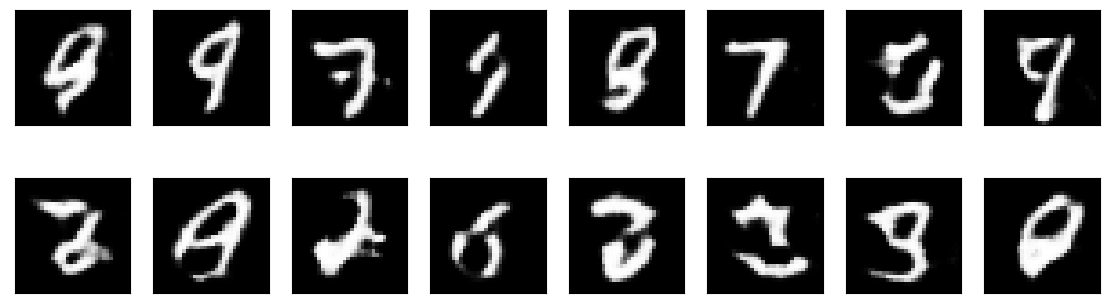

2023-10-18 12:04:08 | Epoch [14/50] | Batch 0/469 | d_loss: 0.6828 | g_loss: 0.6939
2023-10-18 12:04:13 | Epoch [14/50] | Batch 100/469 | d_loss: 0.6430 | g_loss: 0.6933
2023-10-18 12:04:18 | Epoch [14/50] | Batch 200/469 | d_loss: 0.6389 | g_loss: 0.6914
2023-10-18 12:04:24 | Epoch [14/50] | Batch 300/469 | d_loss: 0.6463 | g_loss: 0.6621
2023-10-18 12:04:30 | Epoch [14/50] | Batch 400/469 | d_loss: 0.6397 | g_loss: 0.6935


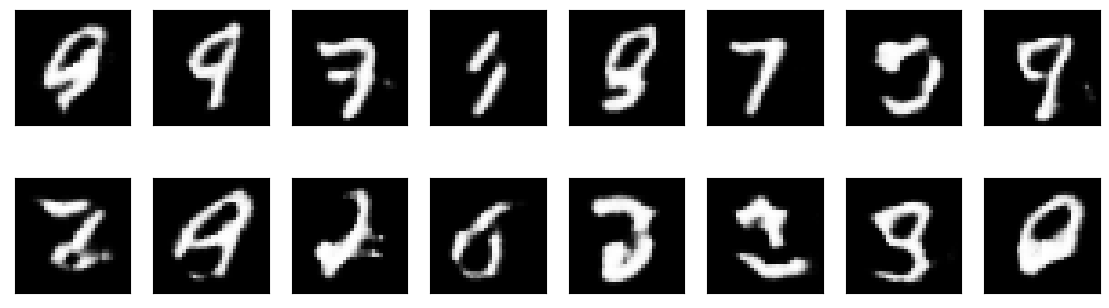

2023-10-18 12:04:36 | Epoch [15/50] | Batch 0/469 | d_loss: 0.6898 | g_loss: 0.6820
2023-10-18 12:04:41 | Epoch [15/50] | Batch 100/469 | d_loss: 0.6372 | g_loss: 0.6929
2023-10-18 12:04:46 | Epoch [15/50] | Batch 200/469 | d_loss: 0.6448 | g_loss: 0.6890
2023-10-18 12:04:51 | Epoch [15/50] | Batch 300/469 | d_loss: 0.6564 | g_loss: 0.6755
2023-10-18 12:04:57 | Epoch [15/50] | Batch 400/469 | d_loss: 0.6344 | g_loss: 0.6893


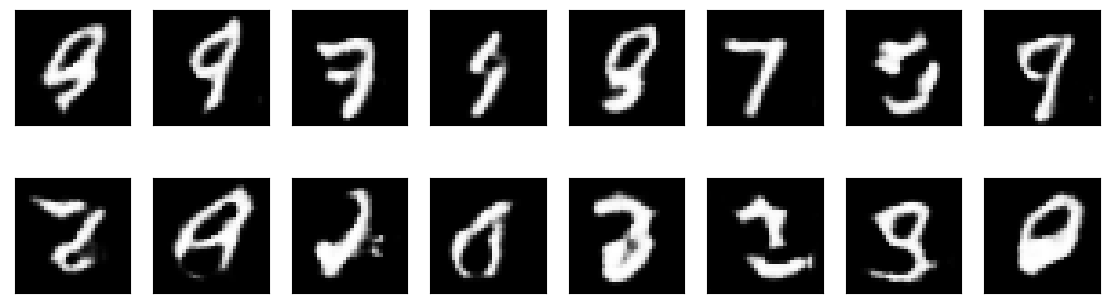

2023-10-18 12:05:02 | Epoch [16/50] | Batch 0/469 | d_loss: 0.6299 | g_loss: 0.6950
2023-10-18 12:05:07 | Epoch [16/50] | Batch 100/469 | d_loss: 0.6786 | g_loss: 0.6684
2023-10-18 12:05:13 | Epoch [16/50] | Batch 200/469 | d_loss: 0.6478 | g_loss: 0.6876
2023-10-18 12:05:18 | Epoch [16/50] | Batch 300/469 | d_loss: 0.6516 | g_loss: 0.6934
2023-10-18 12:05:25 | Epoch [16/50] | Batch 400/469 | d_loss: 0.6431 | g_loss: 0.6947


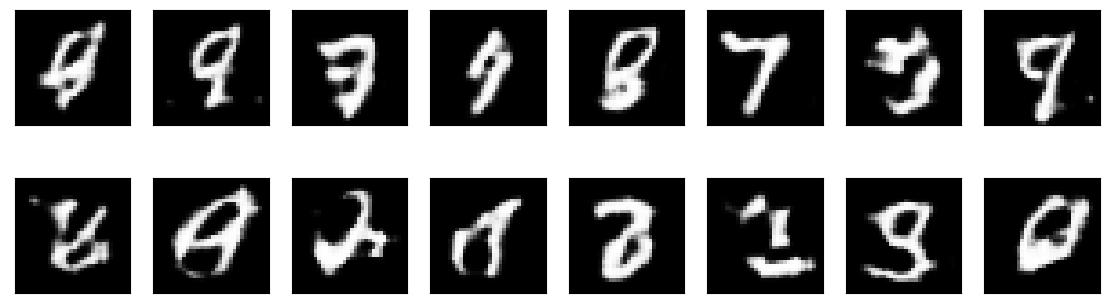

2023-10-18 12:05:30 | Epoch [17/50] | Batch 0/469 | d_loss: 0.6979 | g_loss: 0.6833
2023-10-18 12:05:35 | Epoch [17/50] | Batch 100/469 | d_loss: 0.6409 | g_loss: 0.6941
2023-10-18 12:05:40 | Epoch [17/50] | Batch 200/469 | d_loss: 0.6314 | g_loss: 0.6964
2023-10-18 12:05:46 | Epoch [17/50] | Batch 300/469 | d_loss: 0.6269 | g_loss: 0.6958
2023-10-18 12:05:51 | Epoch [17/50] | Batch 400/469 | d_loss: 0.6262 | g_loss: 0.6935


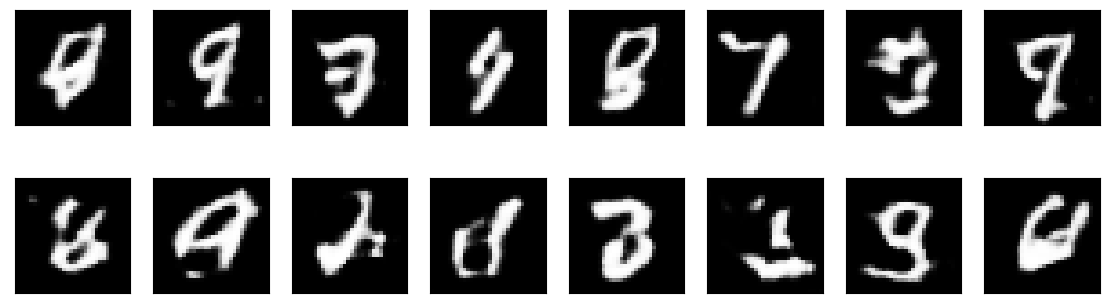

2023-10-18 12:05:57 | Epoch [18/50] | Batch 0/469 | d_loss: 0.6314 | g_loss: 0.6921
2023-10-18 12:06:02 | Epoch [18/50] | Batch 100/469 | d_loss: 0.6278 | g_loss: 0.6959
2023-10-18 12:06:08 | Epoch [18/50] | Batch 200/469 | d_loss: 0.6294 | g_loss: 0.6921
2023-10-18 12:06:13 | Epoch [18/50] | Batch 300/469 | d_loss: 0.6239 | g_loss: 0.6950
2023-10-18 12:06:19 | Epoch [18/50] | Batch 400/469 | d_loss: 0.6250 | g_loss: 0.6916


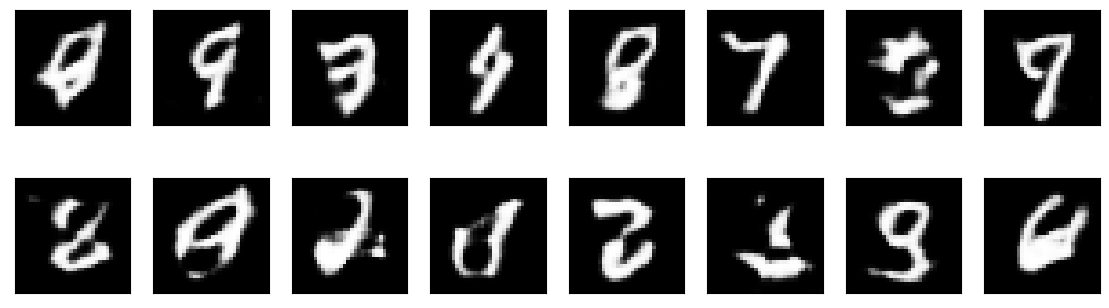

2023-10-18 12:06:24 | Epoch [19/50] | Batch 0/469 | d_loss: 0.6274 | g_loss: 0.6940
2023-10-18 12:06:30 | Epoch [19/50] | Batch 100/469 | d_loss: 0.6265 | g_loss: 0.6935
2023-10-18 12:06:35 | Epoch [19/50] | Batch 200/469 | d_loss: 0.6184 | g_loss: 0.6941
2023-10-18 12:06:40 | Epoch [19/50] | Batch 300/469 | d_loss: 0.6231 | g_loss: 0.6931
2023-10-18 12:06:45 | Epoch [19/50] | Batch 400/469 | d_loss: 0.6196 | g_loss: 0.6940


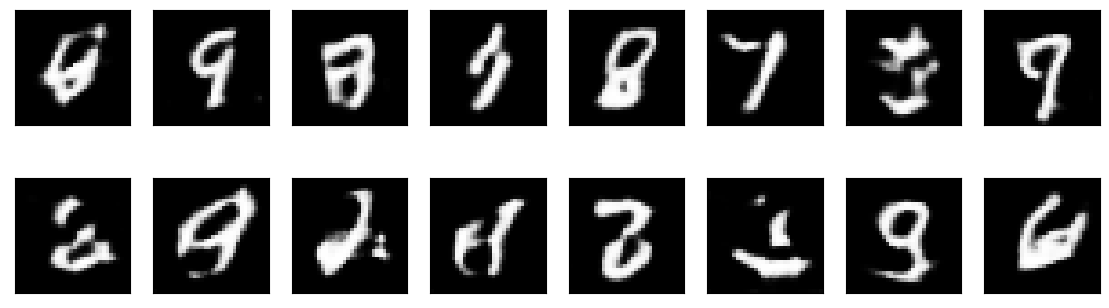

2023-10-18 12:06:51 | Epoch [20/50] | Batch 0/469 | d_loss: 0.6162 | g_loss: 0.6917
2023-10-18 12:06:56 | Epoch [20/50] | Batch 100/469 | d_loss: 0.6783 | g_loss: 0.6774
2023-10-18 12:07:02 | Epoch [20/50] | Batch 200/469 | d_loss: 0.6664 | g_loss: 0.6659
2023-10-18 12:07:08 | Epoch [20/50] | Batch 300/469 | d_loss: 0.6610 | g_loss: 0.6818
2023-10-18 12:07:14 | Epoch [20/50] | Batch 400/469 | d_loss: 0.6297 | g_loss: 0.6956


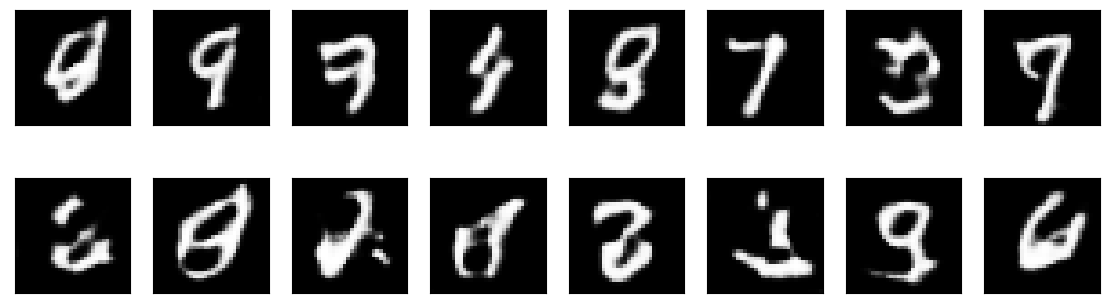

2023-10-18 12:07:19 | Epoch [21/50] | Batch 0/469 | d_loss: 0.6505 | g_loss: 0.6966
2023-10-18 12:07:24 | Epoch [21/50] | Batch 100/469 | d_loss: 0.6620 | g_loss: 0.6430
2023-10-18 12:07:31 | Epoch [21/50] | Batch 200/469 | d_loss: 0.6186 | g_loss: 0.6888
2023-10-18 12:07:36 | Epoch [21/50] | Batch 300/469 | d_loss: 0.6163 | g_loss: 0.6985
2023-10-18 12:07:42 | Epoch [21/50] | Batch 400/469 | d_loss: 0.6196 | g_loss: 0.6990


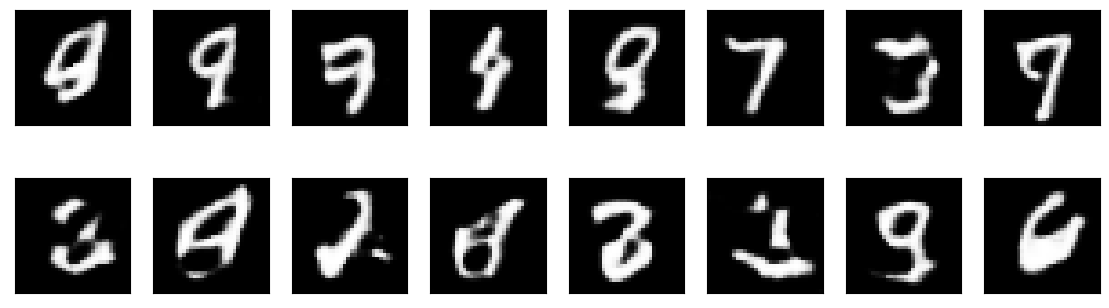

2023-10-18 12:07:47 | Epoch [22/50] | Batch 0/469 | d_loss: 0.6374 | g_loss: 0.6945
2023-10-18 12:07:52 | Epoch [22/50] | Batch 100/469 | d_loss: 0.6148 | g_loss: 0.6708
2023-10-18 12:07:57 | Epoch [22/50] | Batch 200/469 | d_loss: 0.6675 | g_loss: 0.6730
2023-10-18 12:08:03 | Epoch [22/50] | Batch 300/469 | d_loss: 0.6151 | g_loss: 0.6992
2023-10-18 12:08:09 | Epoch [22/50] | Batch 400/469 | d_loss: 0.6119 | g_loss: 0.6979


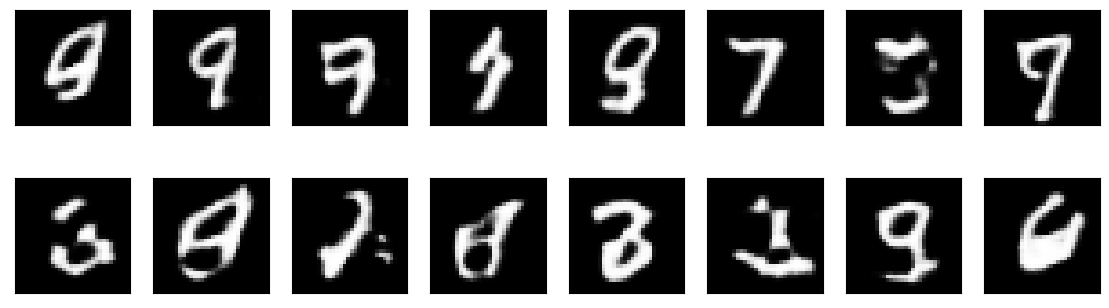

2023-10-18 12:08:15 | Epoch [23/50] | Batch 0/469 | d_loss: 0.6237 | g_loss: 0.6923
2023-10-18 12:08:22 | Epoch [23/50] | Batch 100/469 | d_loss: 0.6109 | g_loss: 0.6956
2023-10-18 12:08:27 | Epoch [23/50] | Batch 200/469 | d_loss: 0.6093 | g_loss: 0.6965
2023-10-18 12:08:32 | Epoch [23/50] | Batch 300/469 | d_loss: 0.6913 | g_loss: 0.6793
2023-10-18 12:08:38 | Epoch [23/50] | Batch 400/469 | d_loss: 0.6097 | g_loss: 0.6984


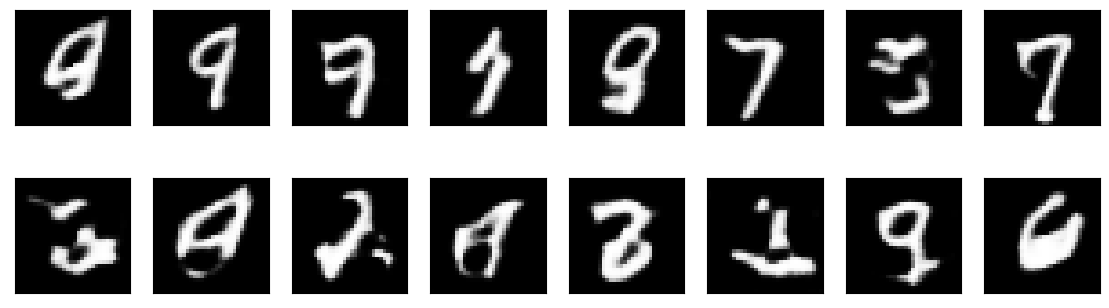

2023-10-18 12:08:43 | Epoch [24/50] | Batch 0/469 | d_loss: 0.6222 | g_loss: 0.6851
2023-10-18 12:08:48 | Epoch [24/50] | Batch 100/469 | d_loss: 0.6079 | g_loss: 0.6991
2023-10-18 12:08:54 | Epoch [24/50] | Batch 200/469 | d_loss: 0.6064 | g_loss: 0.6932
2023-10-18 12:08:59 | Epoch [24/50] | Batch 300/469 | d_loss: 0.6079 | g_loss: 0.6980
2023-10-18 12:09:04 | Epoch [24/50] | Batch 400/469 | d_loss: 0.6078 | g_loss: 0.6893


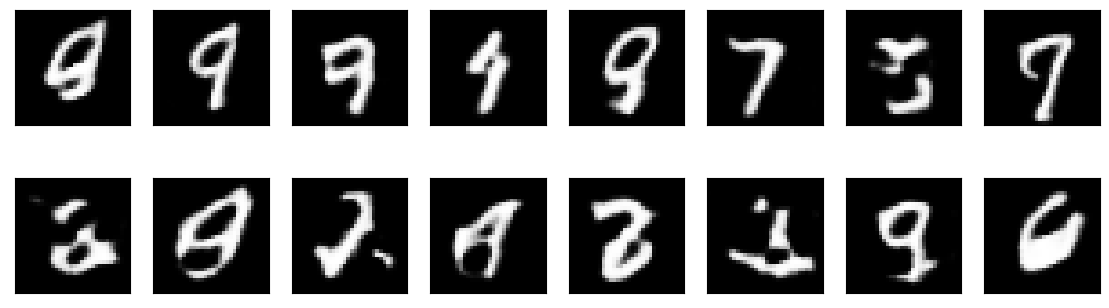

2023-10-18 12:09:10 | Epoch [25/50] | Batch 0/469 | d_loss: 0.6091 | g_loss: 0.6975
2023-10-18 12:09:15 | Epoch [25/50] | Batch 100/469 | d_loss: 0.6060 | g_loss: 0.6951
2023-10-18 12:09:20 | Epoch [25/50] | Batch 200/469 | d_loss: 0.6063 | g_loss: 0.7001
2023-10-18 12:09:25 | Epoch [25/50] | Batch 300/469 | d_loss: 0.6121 | g_loss: 0.6903
2023-10-18 12:09:30 | Epoch [25/50] | Batch 400/469 | d_loss: 0.6032 | g_loss: 0.6960


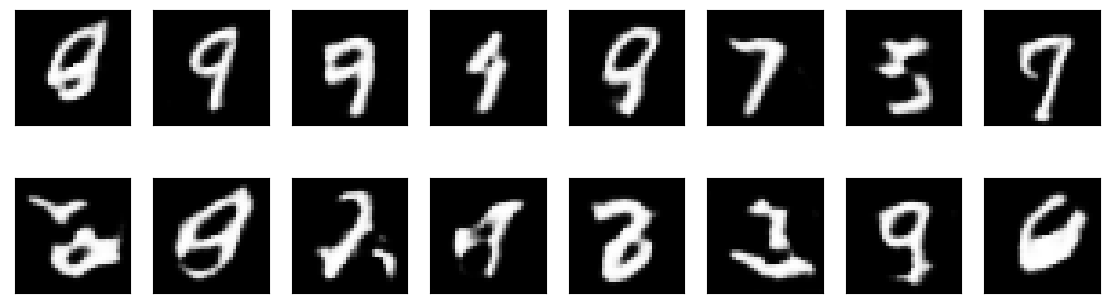

2023-10-18 12:09:35 | Epoch [26/50] | Batch 0/469 | d_loss: 0.6117 | g_loss: 0.7002
2023-10-18 12:09:41 | Epoch [26/50] | Batch 100/469 | d_loss: 0.6022 | g_loss: 0.6935
2023-10-18 12:09:46 | Epoch [26/50] | Batch 200/469 | d_loss: 0.6013 | g_loss: 0.6975
2023-10-18 12:09:52 | Epoch [26/50] | Batch 300/469 | d_loss: 0.6739 | g_loss: 0.6743
2023-10-18 12:09:57 | Epoch [26/50] | Batch 400/469 | d_loss: 0.6473 | g_loss: 0.6878


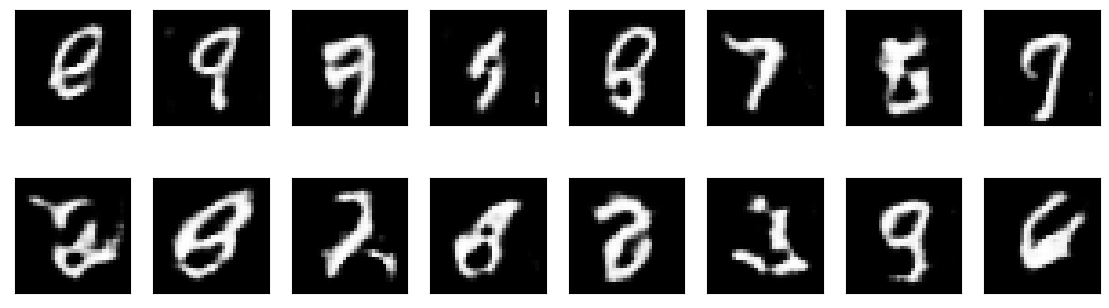

2023-10-18 12:10:03 | Epoch [27/50] | Batch 0/469 | d_loss: 0.6405 | g_loss: 0.6952
2023-10-18 12:10:08 | Epoch [27/50] | Batch 100/469 | d_loss: 0.6256 | g_loss: 0.6911
2023-10-18 12:10:14 | Epoch [27/50] | Batch 200/469 | d_loss: 0.6213 | g_loss: 0.6928
2023-10-18 12:10:19 | Epoch [27/50] | Batch 300/469 | d_loss: 0.6116 | g_loss: 0.7023
2023-10-18 12:10:24 | Epoch [27/50] | Batch 400/469 | d_loss: 0.6051 | g_loss: 0.7007


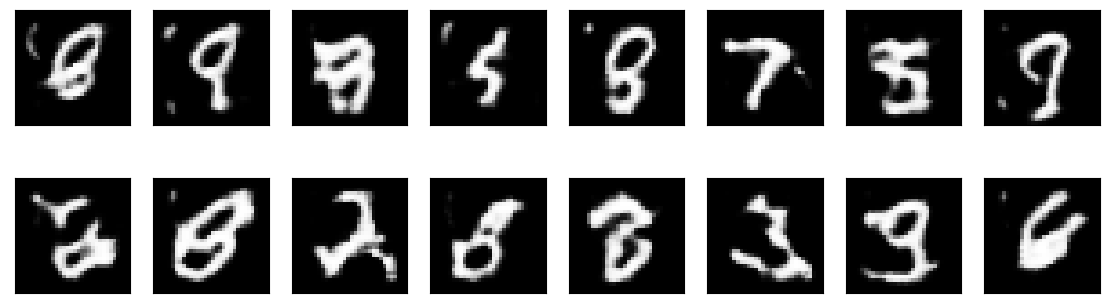

2023-10-18 12:10:30 | Epoch [28/50] | Batch 0/469 | d_loss: 0.6087 | g_loss: 0.7005
2023-10-18 12:10:35 | Epoch [28/50] | Batch 100/469 | d_loss: 0.6284 | g_loss: 0.6878
2023-10-18 12:10:40 | Epoch [28/50] | Batch 200/469 | d_loss: 0.6154 | g_loss: 0.6967
2023-10-18 12:10:46 | Epoch [28/50] | Batch 300/469 | d_loss: 0.6142 | g_loss: 0.6985
2023-10-18 12:10:51 | Epoch [28/50] | Batch 400/469 | d_loss: 0.6040 | g_loss: 0.6984


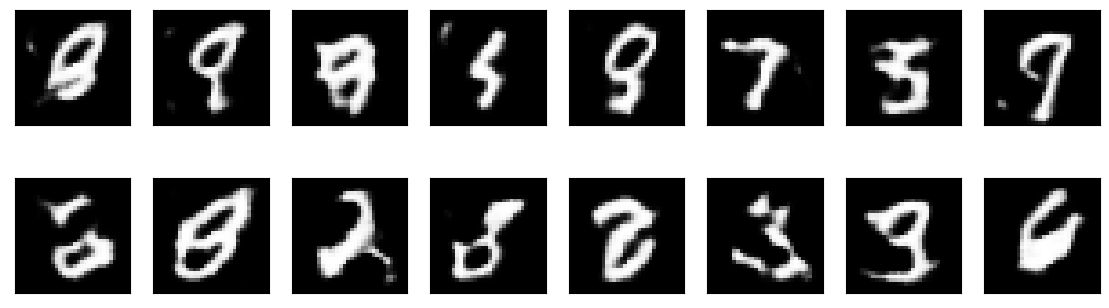

2023-10-18 12:10:57 | Epoch [29/50] | Batch 0/469 | d_loss: 0.6831 | g_loss: 0.6750
2023-10-18 12:11:03 | Epoch [29/50] | Batch 100/469 | d_loss: 0.6041 | g_loss: 0.6932
2023-10-18 12:11:08 | Epoch [29/50] | Batch 200/469 | d_loss: 0.6104 | g_loss: 0.6971
2023-10-18 12:11:14 | Epoch [29/50] | Batch 300/469 | d_loss: 0.6351 | g_loss: 0.6593
2023-10-18 12:11:19 | Epoch [29/50] | Batch 400/469 | d_loss: 0.6057 | g_loss: 0.6992


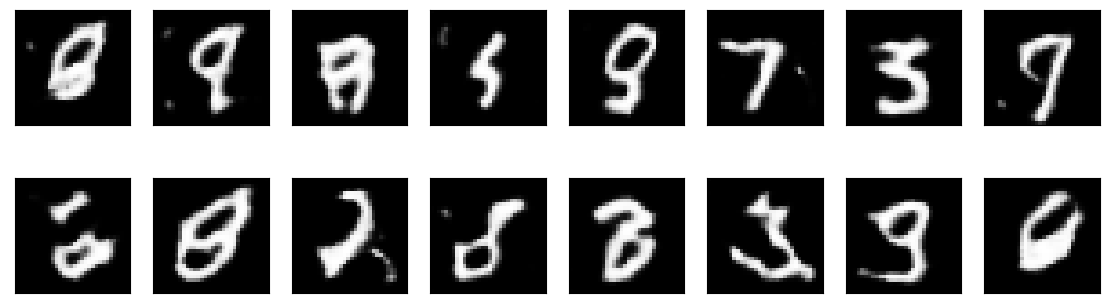

2023-10-18 12:11:24 | Epoch [30/50] | Batch 0/469 | d_loss: 0.6027 | g_loss: 0.6990
2023-10-18 12:11:30 | Epoch [30/50] | Batch 100/469 | d_loss: 0.6039 | g_loss: 0.6987
2023-10-18 12:11:36 | Epoch [30/50] | Batch 200/469 | d_loss: 0.6972 | g_loss: 0.6894
2023-10-18 12:11:41 | Epoch [30/50] | Batch 300/469 | d_loss: 0.6385 | g_loss: 0.6896
2023-10-18 12:11:46 | Epoch [30/50] | Batch 400/469 | d_loss: 0.5997 | g_loss: 0.6998


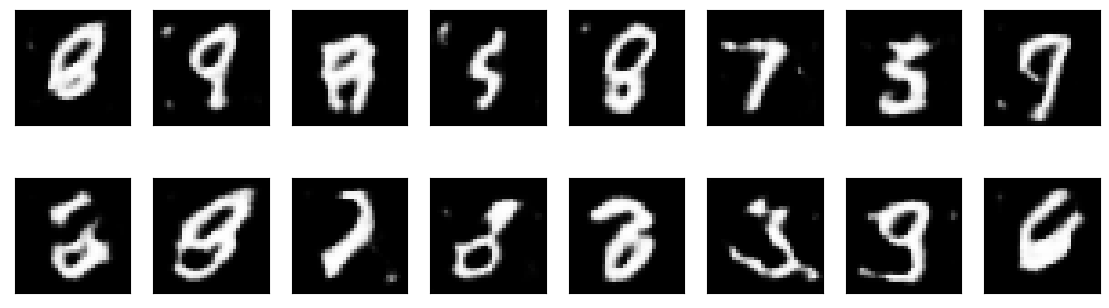

2023-10-18 12:11:52 | Epoch [31/50] | Batch 0/469 | d_loss: 0.5973 | g_loss: 0.6984
2023-10-18 12:11:57 | Epoch [31/50] | Batch 100/469 | d_loss: 0.5990 | g_loss: 0.6957
2023-10-18 12:12:02 | Epoch [31/50] | Batch 200/469 | d_loss: 0.6014 | g_loss: 0.6960
2023-10-18 12:12:08 | Epoch [31/50] | Batch 300/469 | d_loss: 0.5975 | g_loss: 0.6975
2023-10-18 12:12:13 | Epoch [31/50] | Batch 400/469 | d_loss: 0.5956 | g_loss: 0.6983


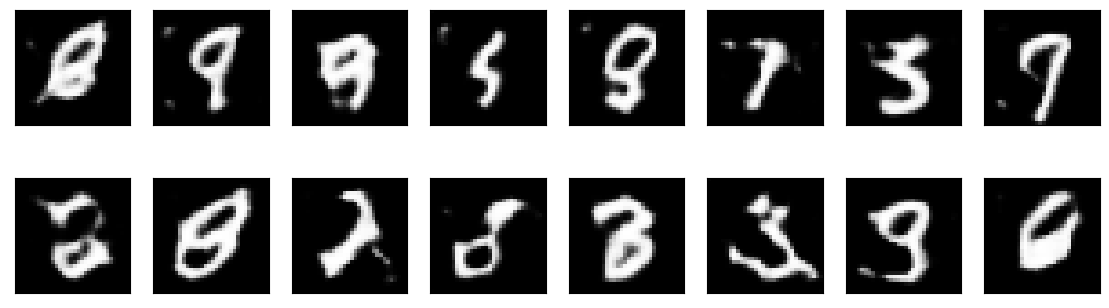

2023-10-18 12:12:18 | Epoch [32/50] | Batch 0/469 | d_loss: 0.5977 | g_loss: 0.6981
2023-10-18 12:12:24 | Epoch [32/50] | Batch 100/469 | d_loss: 0.5975 | g_loss: 0.6960
2023-10-18 12:12:29 | Epoch [32/50] | Batch 200/469 | d_loss: 0.6782 | g_loss: 0.6646
2023-10-18 12:12:35 | Epoch [32/50] | Batch 300/469 | d_loss: 0.6424 | g_loss: 0.6906
2023-10-18 12:12:40 | Epoch [32/50] | Batch 400/469 | d_loss: 0.6703 | g_loss: 0.6830


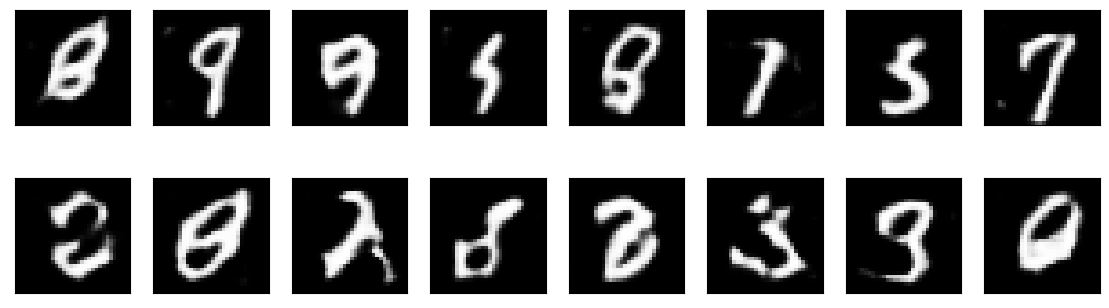

2023-10-18 12:12:45 | Epoch [33/50] | Batch 0/469 | d_loss: 0.6891 | g_loss: 0.6905
2023-10-18 12:12:50 | Epoch [33/50] | Batch 100/469 | d_loss: 0.5967 | g_loss: 0.7019
2023-10-18 12:12:56 | Epoch [33/50] | Batch 200/469 | d_loss: 0.5929 | g_loss: 0.6983
2023-10-18 12:13:01 | Epoch [33/50] | Batch 300/469 | d_loss: 0.6861 | g_loss: 0.6821
2023-10-18 12:13:07 | Epoch [33/50] | Batch 400/469 | d_loss: 0.6016 | g_loss: 0.6977


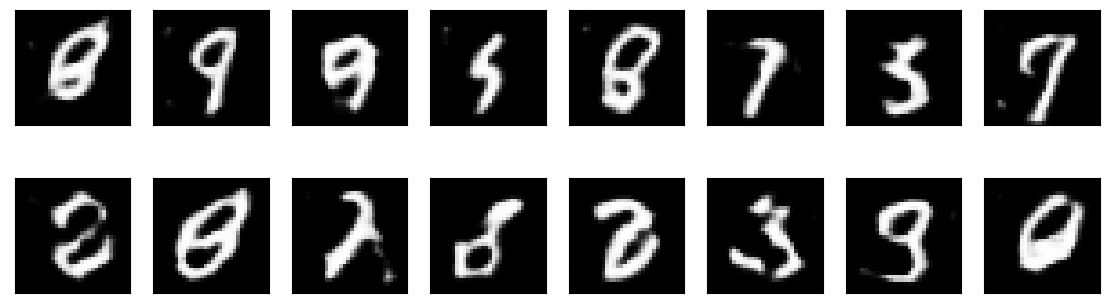

2023-10-18 12:13:12 | Epoch [34/50] | Batch 0/469 | d_loss: 0.6885 | g_loss: 0.6864
2023-10-18 12:13:18 | Epoch [34/50] | Batch 100/469 | d_loss: 0.6047 | g_loss: 0.6929
2023-10-18 12:13:23 | Epoch [34/50] | Batch 200/469 | d_loss: 0.5974 | g_loss: 0.7020
2023-10-18 12:13:29 | Epoch [34/50] | Batch 300/469 | d_loss: 0.5953 | g_loss: 0.7014
2023-10-18 12:13:35 | Epoch [34/50] | Batch 400/469 | d_loss: 0.6024 | g_loss: 0.7000


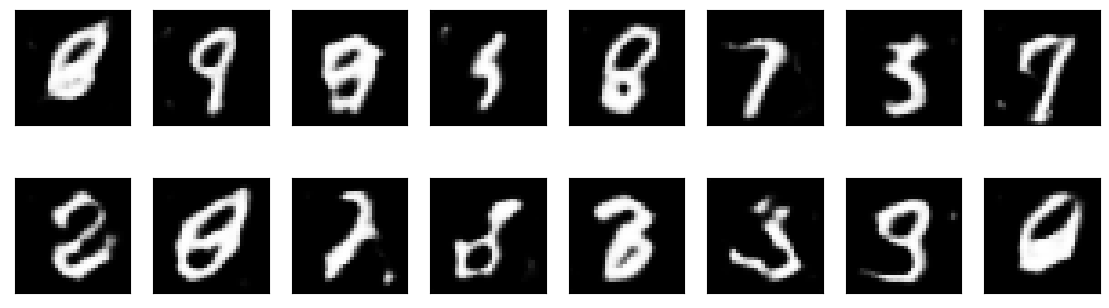

2023-10-18 12:13:41 | Epoch [35/50] | Batch 0/469 | d_loss: 0.5945 | g_loss: 0.7031
2023-10-18 12:13:46 | Epoch [35/50] | Batch 100/469 | d_loss: 0.5977 | g_loss: 0.7028
2023-10-18 12:13:51 | Epoch [35/50] | Batch 200/469 | d_loss: 0.5927 | g_loss: 0.6976
2023-10-18 12:13:56 | Epoch [35/50] | Batch 300/469 | d_loss: 0.5875 | g_loss: 0.7020
2023-10-18 12:14:01 | Epoch [35/50] | Batch 400/469 | d_loss: 0.5884 | g_loss: 0.7000


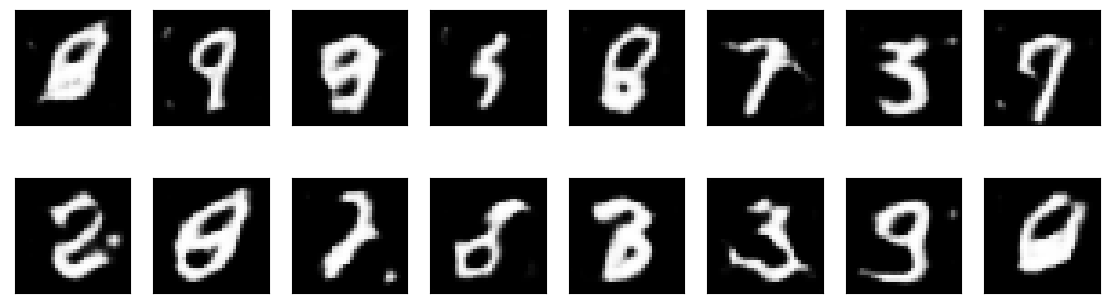

2023-10-18 12:14:06 | Epoch [36/50] | Batch 0/469 | d_loss: 0.5905 | g_loss: 0.6974
2023-10-18 12:14:11 | Epoch [36/50] | Batch 100/469 | d_loss: 0.5939 | g_loss: 0.6987
2023-10-18 12:14:17 | Epoch [36/50] | Batch 200/469 | d_loss: 0.5907 | g_loss: 0.6992
2023-10-18 12:14:23 | Epoch [36/50] | Batch 300/469 | d_loss: 0.5900 | g_loss: 0.6984
2023-10-18 12:14:29 | Epoch [36/50] | Batch 400/469 | d_loss: 0.5957 | g_loss: 0.6977


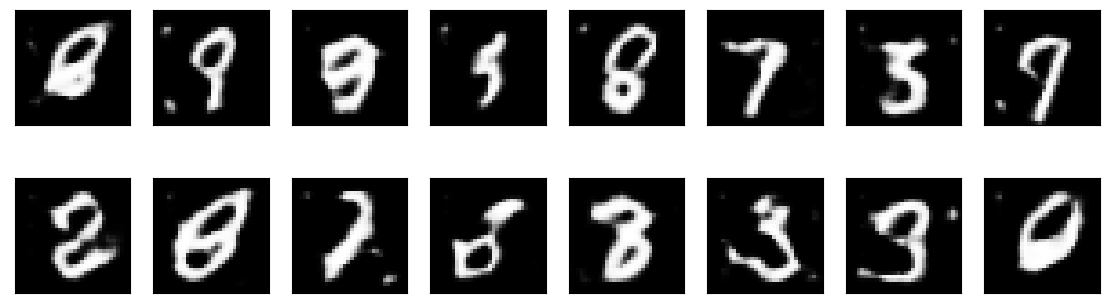

2023-10-18 12:14:34 | Epoch [37/50] | Batch 0/469 | d_loss: 0.5901 | g_loss: 0.6989
2023-10-18 12:14:39 | Epoch [37/50] | Batch 100/469 | d_loss: 0.5899 | g_loss: 0.6985
2023-10-18 12:14:45 | Epoch [37/50] | Batch 200/469 | d_loss: 0.6864 | g_loss: 0.6758
2023-10-18 12:14:51 | Epoch [37/50] | Batch 300/469 | d_loss: 0.6119 | g_loss: 0.6901
2023-10-18 12:14:56 | Epoch [37/50] | Batch 400/469 | d_loss: 0.5991 | g_loss: 0.6996


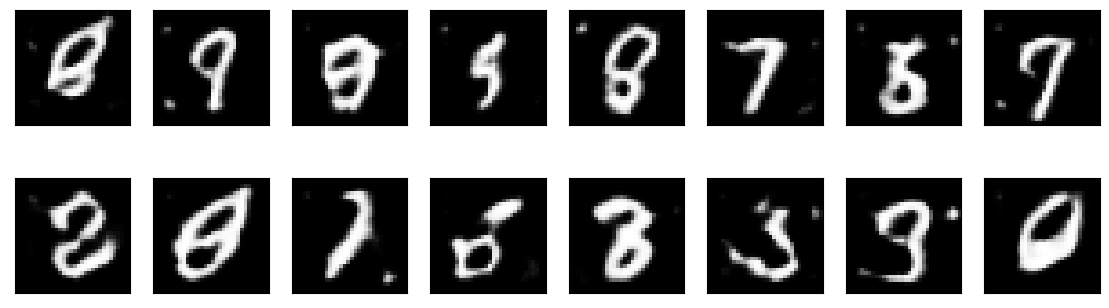

2023-10-18 12:15:01 | Epoch [38/50] | Batch 0/469 | d_loss: 0.5916 | g_loss: 0.7014
2023-10-18 12:15:06 | Epoch [38/50] | Batch 100/469 | d_loss: 0.5895 | g_loss: 0.7008
2023-10-18 12:15:12 | Epoch [38/50] | Batch 200/469 | d_loss: 0.5928 | g_loss: 0.6979
2023-10-18 12:15:17 | Epoch [38/50] | Batch 300/469 | d_loss: 0.5841 | g_loss: 0.6997
2023-10-18 12:15:22 | Epoch [38/50] | Batch 400/469 | d_loss: 0.5855 | g_loss: 0.6987


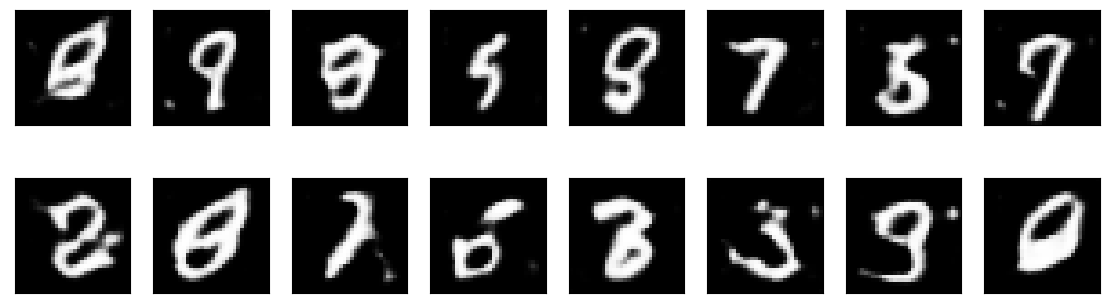

2023-10-18 12:15:28 | Epoch [39/50] | Batch 0/469 | d_loss: 0.5977 | g_loss: 0.6898
2023-10-18 12:15:33 | Epoch [39/50] | Batch 100/469 | d_loss: 0.6529 | g_loss: 0.6855
2023-10-18 12:15:38 | Epoch [39/50] | Batch 200/469 | d_loss: 0.6353 | g_loss: 0.6869
2023-10-18 12:15:44 | Epoch [39/50] | Batch 300/469 | d_loss: 0.6223 | g_loss: 0.6971
2023-10-18 12:15:49 | Epoch [39/50] | Batch 400/469 | d_loss: 0.6181 | g_loss: 0.6964


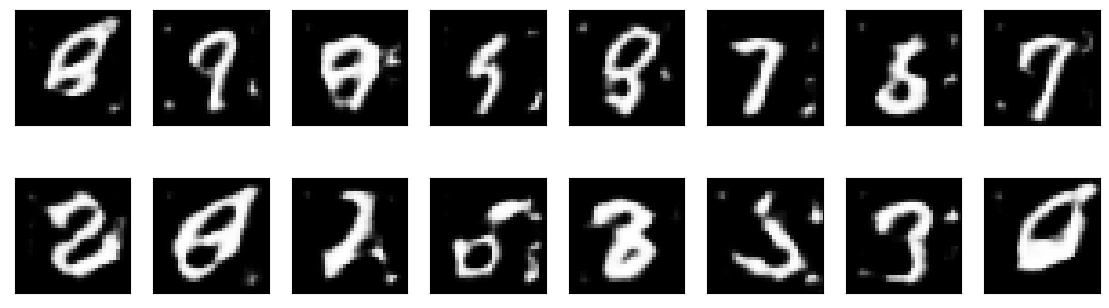

2023-10-18 12:15:54 | Epoch [40/50] | Batch 0/469 | d_loss: 0.6472 | g_loss: 0.6851
2023-10-18 12:16:00 | Epoch [40/50] | Batch 100/469 | d_loss: 0.6268 | g_loss: 0.6818
2023-10-18 12:16:05 | Epoch [40/50] | Batch 200/469 | d_loss: 0.6202 | g_loss: 0.7002
2023-10-18 12:16:11 | Epoch [40/50] | Batch 300/469 | d_loss: 0.5998 | g_loss: 0.7022
2023-10-18 12:16:17 | Epoch [40/50] | Batch 400/469 | d_loss: 0.5966 | g_loss: 0.7029


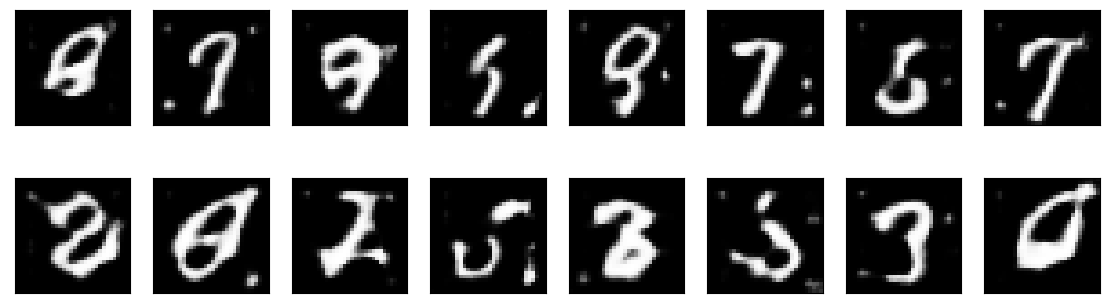

2023-10-18 12:16:22 | Epoch [41/50] | Batch 0/469 | d_loss: 0.6033 | g_loss: 0.6940
2023-10-18 12:16:27 | Epoch [41/50] | Batch 100/469 | d_loss: 0.5934 | g_loss: 0.7021
2023-10-18 12:16:33 | Epoch [41/50] | Batch 200/469 | d_loss: 0.5938 | g_loss: 0.7016
2023-10-18 12:16:38 | Epoch [41/50] | Batch 300/469 | d_loss: 0.5918 | g_loss: 0.7035
2023-10-18 12:16:43 | Epoch [41/50] | Batch 400/469 | d_loss: 0.5966 | g_loss: 0.6993


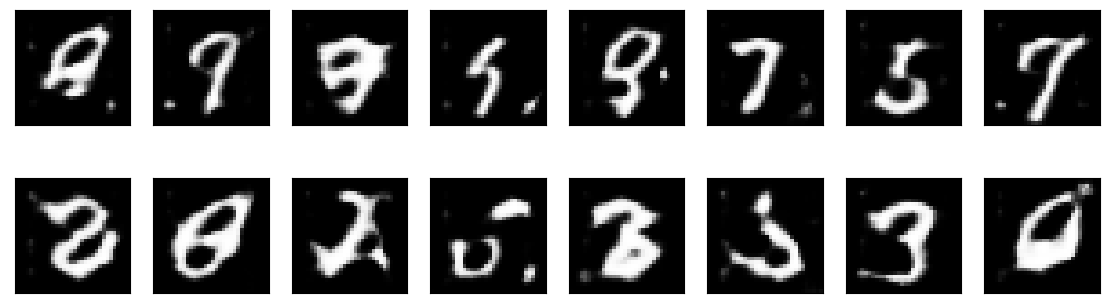

2023-10-18 12:16:48 | Epoch [42/50] | Batch 0/469 | d_loss: 0.6428 | g_loss: 0.6881
2023-10-18 12:16:53 | Epoch [42/50] | Batch 100/469 | d_loss: 0.5932 | g_loss: 0.6989
2023-10-18 12:16:59 | Epoch [42/50] | Batch 200/469 | d_loss: 0.5980 | g_loss: 0.7016
2023-10-18 12:17:04 | Epoch [42/50] | Batch 300/469 | d_loss: 0.5923 | g_loss: 0.7025
2023-10-18 12:17:09 | Epoch [42/50] | Batch 400/469 | d_loss: 0.6806 | g_loss: 0.6874


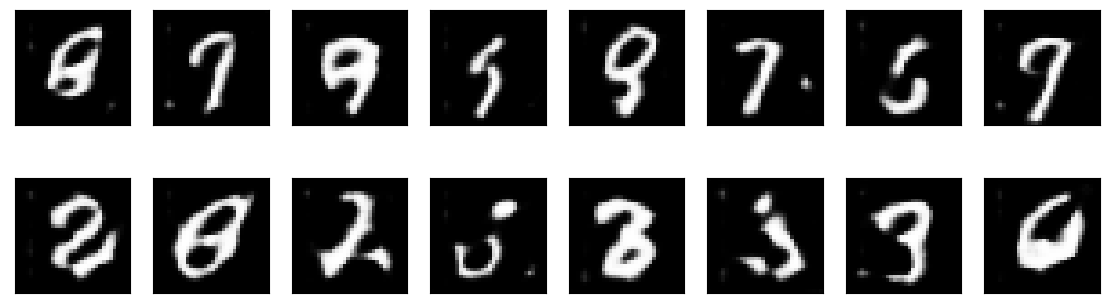

2023-10-18 12:17:15 | Epoch [43/50] | Batch 0/469 | d_loss: 0.5933 | g_loss: 0.6979
2023-10-18 12:17:21 | Epoch [43/50] | Batch 100/469 | d_loss: 0.7053 | g_loss: 0.6741
2023-10-18 12:17:27 | Epoch [43/50] | Batch 200/469 | d_loss: 0.6670 | g_loss: 0.6837
2023-10-18 12:17:32 | Epoch [43/50] | Batch 300/469 | d_loss: 0.5914 | g_loss: 0.7050
2023-10-18 12:17:38 | Epoch [43/50] | Batch 400/469 | d_loss: 0.5909 | g_loss: 0.7044


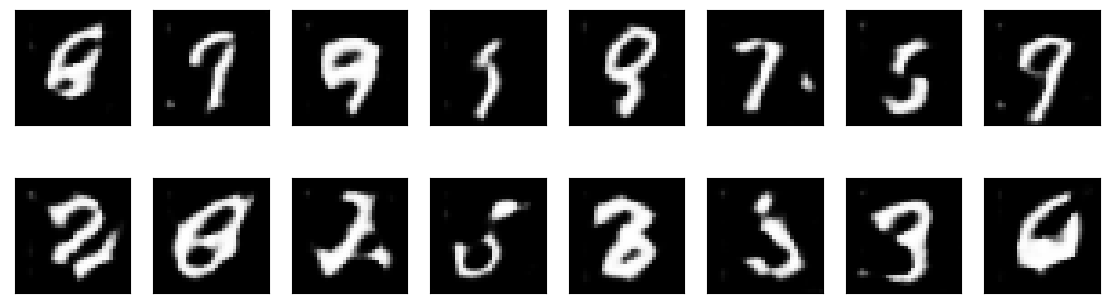

2023-10-18 12:17:44 | Epoch [44/50] | Batch 0/469 | d_loss: 0.5895 | g_loss: 0.7012
2023-10-18 12:17:50 | Epoch [44/50] | Batch 100/469 | d_loss: 0.5910 | g_loss: 0.7007
2023-10-18 12:17:55 | Epoch [44/50] | Batch 200/469 | d_loss: 0.5851 | g_loss: 0.7013
2023-10-18 12:18:02 | Epoch [44/50] | Batch 300/469 | d_loss: 0.5895 | g_loss: 0.7027
2023-10-18 12:18:07 | Epoch [44/50] | Batch 400/469 | d_loss: 0.5897 | g_loss: 0.6883


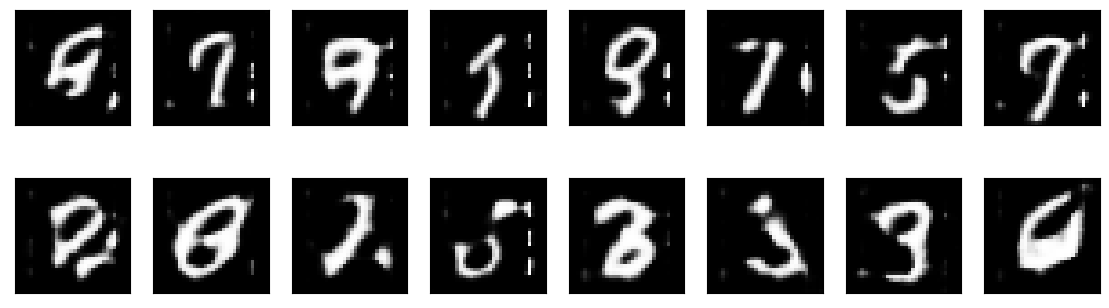

2023-10-18 12:18:13 | Epoch [45/50] | Batch 0/469 | d_loss: 0.5919 | g_loss: 0.7022
2023-10-18 12:18:18 | Epoch [45/50] | Batch 100/469 | d_loss: 0.5880 | g_loss: 0.6959
2023-10-18 12:18:24 | Epoch [45/50] | Batch 200/469 | d_loss: 0.5822 | g_loss: 0.6949
2023-10-18 12:18:29 | Epoch [45/50] | Batch 300/469 | d_loss: 0.5846 | g_loss: 0.7014
2023-10-18 12:18:34 | Epoch [45/50] | Batch 400/469 | d_loss: 0.5829 | g_loss: 0.7008


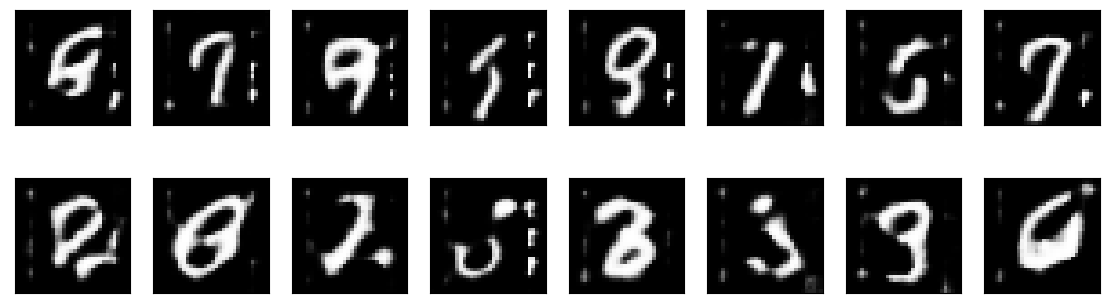

2023-10-18 12:18:40 | Epoch [46/50] | Batch 0/469 | d_loss: 0.5820 | g_loss: 0.7000
2023-10-18 12:18:45 | Epoch [46/50] | Batch 100/469 | d_loss: 0.5821 | g_loss: 0.6984
2023-10-18 12:18:51 | Epoch [46/50] | Batch 200/469 | d_loss: 0.5842 | g_loss: 0.6982
2023-10-18 12:18:57 | Epoch [46/50] | Batch 300/469 | d_loss: 0.5857 | g_loss: 0.7002
2023-10-18 12:19:03 | Epoch [46/50] | Batch 400/469 | d_loss: 0.5925 | g_loss: 0.6766


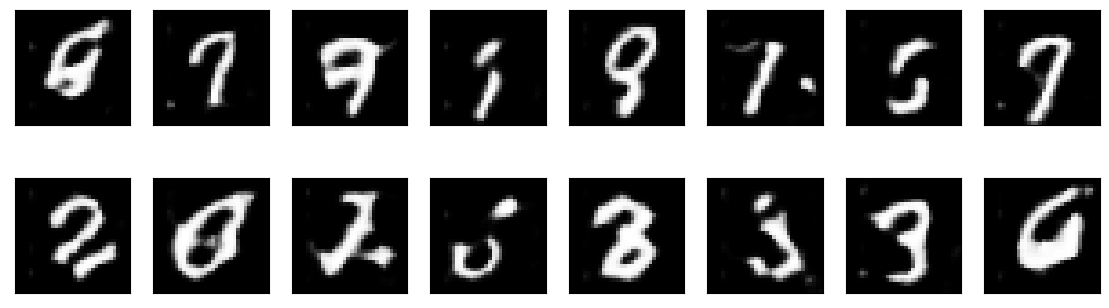

2023-10-18 12:19:08 | Epoch [47/50] | Batch 0/469 | d_loss: 0.6731 | g_loss: 0.6784
2023-10-18 12:19:14 | Epoch [47/50] | Batch 100/469 | d_loss: 0.6816 | g_loss: 0.6834
2023-10-18 12:19:19 | Epoch [47/50] | Batch 200/469 | d_loss: 0.7008 | g_loss: 0.6885
2023-10-18 12:19:24 | Epoch [47/50] | Batch 300/469 | d_loss: 0.5892 | g_loss: 0.7022
2023-10-18 12:19:29 | Epoch [47/50] | Batch 400/469 | d_loss: 0.5853 | g_loss: 0.7030


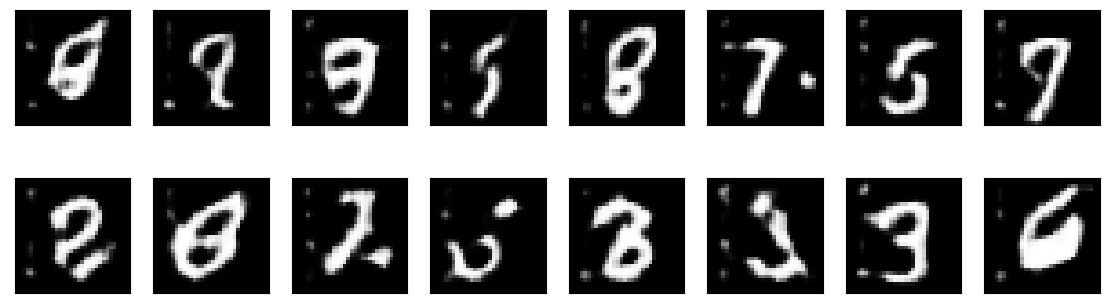

2023-10-18 12:19:35 | Epoch [48/50] | Batch 0/469 | d_loss: 0.5854 | g_loss: 0.7014
2023-10-18 12:19:40 | Epoch [48/50] | Batch 100/469 | d_loss: 0.5826 | g_loss: 0.6998
2023-10-18 12:19:46 | Epoch [48/50] | Batch 200/469 | d_loss: 0.5833 | g_loss: 0.6967
2023-10-18 12:19:51 | Epoch [48/50] | Batch 300/469 | d_loss: 0.6732 | g_loss: 0.6678
2023-10-18 12:19:57 | Epoch [48/50] | Batch 400/469 | d_loss: 0.6639 | g_loss: 0.6689


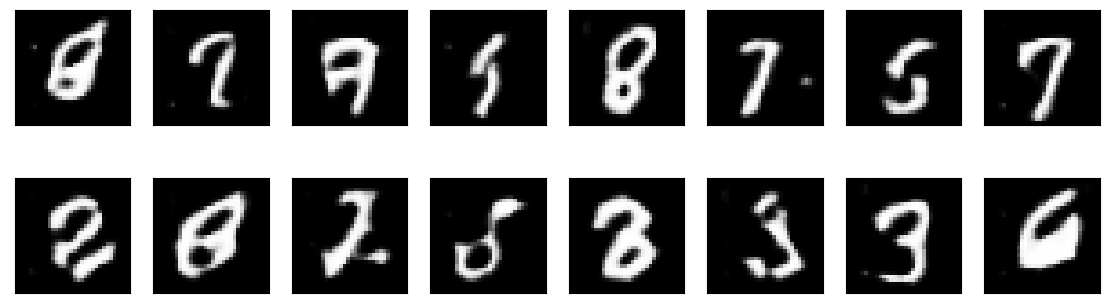

2023-10-18 12:20:02 | Epoch [49/50] | Batch 0/469 | d_loss: 0.6564 | g_loss: 0.6804
2023-10-18 12:20:08 | Epoch [49/50] | Batch 100/469 | d_loss: 0.6143 | g_loss: 0.6890
2023-10-18 12:20:13 | Epoch [49/50] | Batch 200/469 | d_loss: 0.5992 | g_loss: 0.7047
2023-10-18 12:20:18 | Epoch [49/50] | Batch 300/469 | d_loss: 0.6033 | g_loss: 0.7006
2023-10-18 12:20:23 | Epoch [49/50] | Batch 400/469 | d_loss: 0.5946 | g_loss: 0.7037


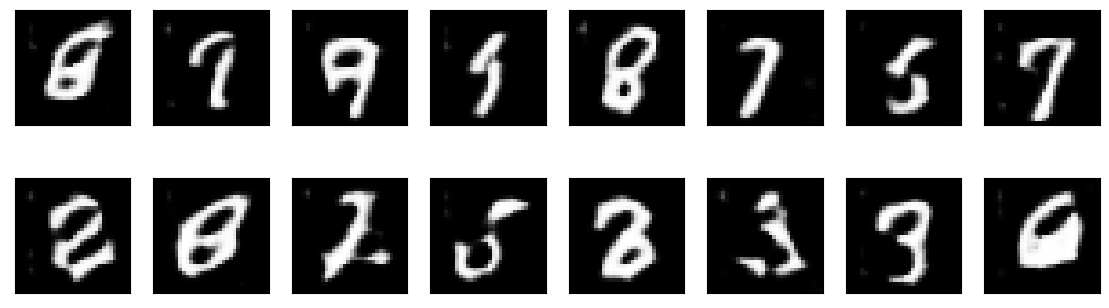

2023-10-18 12:20:29 | Epoch [50/50] | Batch 0/469 | d_loss: 0.5974 | g_loss: 0.7004
2023-10-18 12:20:34 | Epoch [50/50] | Batch 100/469 | d_loss: 0.5872 | g_loss: 0.7060
2023-10-18 12:20:39 | Epoch [50/50] | Batch 200/469 | d_loss: 0.5891 | g_loss: 0.7053
2023-10-18 12:20:45 | Epoch [50/50] | Batch 300/469 | d_loss: 0.5891 | g_loss: 0.7053
2023-10-18 12:20:50 | Epoch [50/50] | Batch 400/469 | d_loss: 0.6453 | g_loss: 0.6570


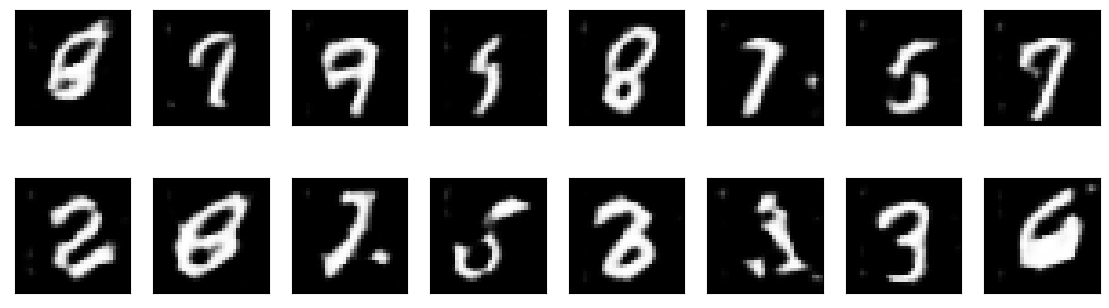

In [141]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
D.to(device)
G.to(device)
# training hyperparams
num_epochs = 50

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 100

# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size = 16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size, 1, 1))
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.to(device)
# train the network
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        ## Important rescaling step ## 
        real_images = real_images*2 - 1  # rescale input images from [0,1) to [-1, 1)
        
        real_images = real_images.to(device)
        
        # ============================================
        #            TRAIN THE DISCRIMINATOR
        # ============================================
        
        d_optimizer.zero_grad()
        
        # 1. Train with real images

        # Compute the discriminator losses on real images 
        # smooth the real labels
        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=False)
        
        # 2. Train with fake images
        
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size, 1, 1))
        z = torch.from_numpy(z).float()
        z = z.to(device)
        fake_images = G(z)
        fake_images = fake_images.to(device)
        
        # Compute the discriminator losses on fake images        
        D_fake = D(fake_images.detach()) # The fake input is detached from the generator (while updating the discriminator), so that the generator won’t see any gradients
        d_fake_loss = fake_loss(D_fake)
        
        # add up loss and perform backprop
        d_loss = (d_real_loss + d_fake_loss)/2
        d_loss.backward()
        d_optimizer.step()
        
        
        # =========================================
        #            TRAIN THE GENERATOR
        # =========================================
        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        # no need to generate another fake image, just use the one generated above
#         # Generate fake images
#         z = np.random.uniform(-1, 1, size=(batch_size, z_size))
#         z = torch.from_numpy(z).float()
#         z = z.to(device)
#         fake_images = fake_images.to(device)
#         fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels!
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{num_epochs}] | Batch {batch_i}/{len(train_loader)} | d_loss: {d_loss.item():.4f} | g_loss: {g_loss.item():.4f}')
    
            ## AFTER EACH EPOCH##
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
    
    # generate and save sample, fake images
    G.eval() # eval mode for generating samples
    with torch.no_grad():
        samples_z = G(fixed_z)
    samples.append(samples_z)
    view_samples(-1, samples)
    G.train() # back to train mode


# Save training generator samples
with open('train_samples2.pkl', 'wb') as f:
    pkl.dump(samples, f)

## Training loss

Here we'll plot the training losses for the generator and discriminator, recorded after each epoch.

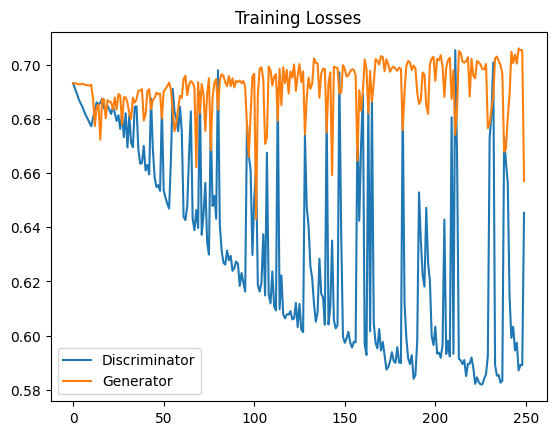

In [142]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator samples from training

Here we can view samples of images from the generator. First we'll look at the images we saved during training.

In [143]:
# Load samples from generator, taken while training
with open('train_samples2.pkl', 'rb') as f:
    samples = pkl.load(f)

These are samples from the final training epoch. You can see the generator is able to reproduce numbers like 1, 7, 3, 2. Since this is just a sample, it isn't representative of the full range of images this generator can make.

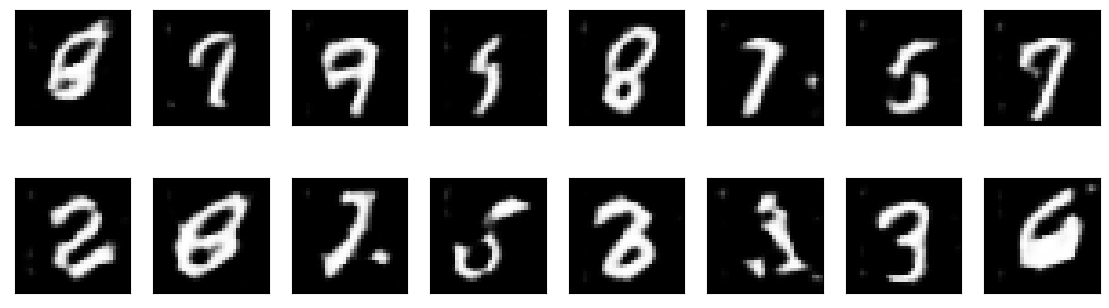

In [144]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

Below I'm showing the generated images as the network was training, every 10 epochs.

In [167]:
print(int(len(samples)/rows))
print(int(len(samples)/cols))

5
3


In [165]:
print(samples[1].shape)
print(len(samples))

torch.Size([16, 1, 32, 32])
50


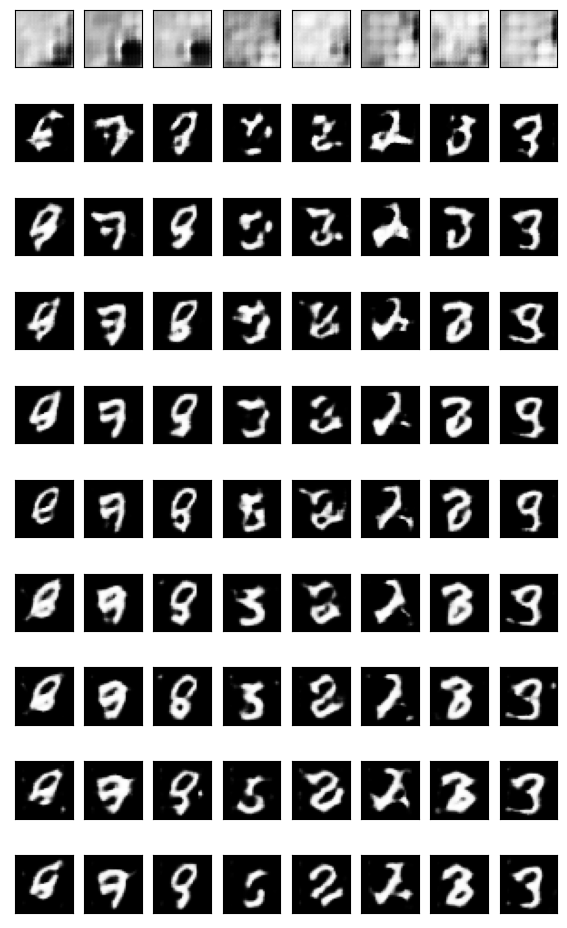

In [172]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 8
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    # print(ax_row)
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.to('cpu').numpy().reshape((32,32)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

## Sampling from the generator

We can also get completely new images from the generator by using the checkpoint we saved after training. **We just need to pass in a new latent vector $z$ and we'll get new samples**!

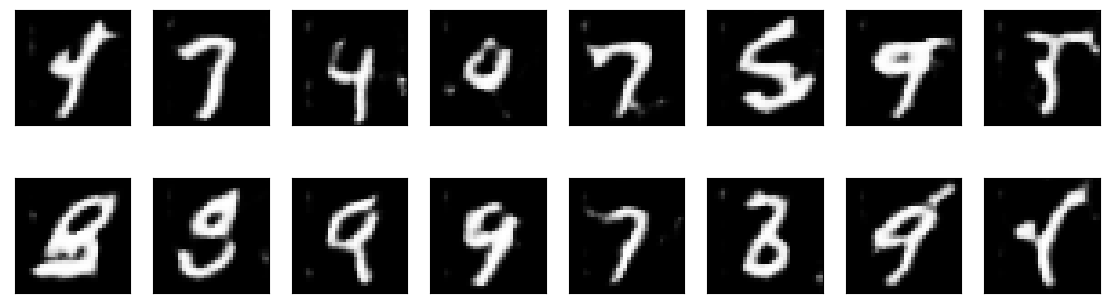

In [148]:
# randomly generated, new latent vectors
sample_size = 16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size, 1, 1))
rand_z = torch.from_numpy(rand_z).float()

rand_z = rand_z.to(device)

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])